In [ ]:
import numpy as np

loaded_files = []
loaded_fileNAMES = []

global_xs = []
global_ys = []
global_ts = []

global_xs_cent = []
global_ys_cent = []
global_ts_cent = []

image = np.zeros((256,256), dtype = np.int32)
image_centroided = np.zeros((256,256), dtype = np.int32)
global_TOF = np.zeros(11810, dtype = np.int32)
global_TOF_centroided = np.zeros(11810, dtype = np.int32)
radial = np.zeros((256), dtype = np.float)
radial_list = []
peaks_raw = []
peaks_centroided = []
mini_ims = []
disp_images = []

In [6]:
GLITCH_THRESHOLD = 15000

XMIN = 0
XMAX = 255
YMIN = 0
YMAX = 255

TMIN = 0
TMAX = 11810

TCUT = 7900

data_path = 'D:\\Merlin\\Data\\Run15\\'
prefix = '?*'

In [7]:
LoadFiles(maxfiles = 500)

Loaded 100 files in 6389 ms
Loaded 200 files in 6390 ms
Loaded 300 files in 6520 ms
Loaded 400 files in 6369 ms
Finished loading 456 more files
Average ions/frame = 158.712719298


In [ ]:
Reset()

In [ ]:
print len(loaded_fileNAMES)

In [ ]:
a=1

In [ ]:
LoadLastFiles(nfiles = 1, clear = True)

In [ ]:
# TCUT = 8440
TCUT = 5000
# LoadFiles(maxfiles=1)
ShowExampleImage(tcut=TCUT)

       Raw peaks found at [8505, 8475, 8432, 8394, 8379, 8350, 8316, 8267, 8237, 8215, 8168]
Centroided peaks found at [8506, 8477, 8464, 8434, 8401, 8395, 8379, 8353, 8317, 8268, 8240, 8232, 8217, 8170, 8151]


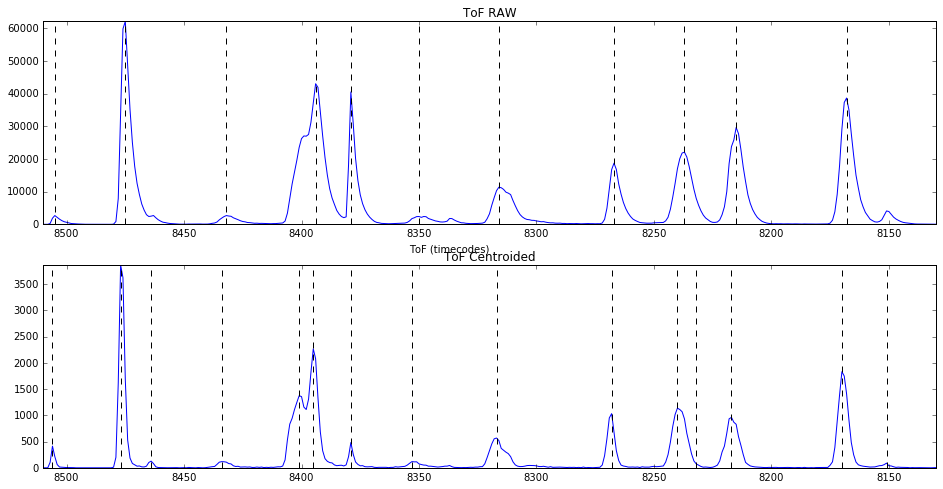

In [8]:
# TOF_TMIN = 8250
# TOF_TMAX = 8320

TOF_TMIN = 8130
TOF_TMAX = 8510
# TCUT = 8440
ax_raw, ax_cent = ShowTOF(flip=True, centroided=True, v_scale=1)

In [ ]:
# Reset()
t0 = time.time()
ShowEverything(recreate=True)
print 'Created in %s s'%(time.time()-t0)

In [ ]:
global radial_list

# width = 10
# peak = 8302
# TMIN = peak - width
# TMAX = peak + width

width = 10
peak = 8267
TMIN = peak - width
TMAX = peak + width

FILES_PER_LOOP = 400
N_LOOPS = 62

x = 111
y = 124

filenames = glob.glob(join(data_path, prefix))
_files = {}

for _filename in filenames:
    _id = FilenameToFileID(_filename)
    _files[_id] = _filename
print 'Found %s files'%len(filenames)

n_loops = 0
n_loaded = 0
t0 = time.time()
for n_loops in range(N_LOOPS):
    for _fileID in sorted(_files.keys())[n_loops*FILES_PER_LOOP:(n_loops+1)*FILES_PER_LOOP]:
        _filename = _files[_fileID]
        n_loaded += 1
        if n_loaded%100 == 0:
            dt = time.time() - t0
            print 'Loaded %s files in %.0f ms' %(n_loaded, dt*1e3)
            t0 = time.time()
        _xs, _ys, _ts = GetXYTarray_SingleFile(_filename)
        global_xs.extend(_xs)
        global_ys.extend(_ys)
        global_ts.extend(_ts)

    MakeVMIImage()

    ShowVMI(centroids=[y,x])#, zoom=([100,150],[100,150]))
    PlotRadial(image,x,y)
    radial_list.append(np.copy(radial))
    print 'Finished %s loops'%(n_loops+1)
    Reset()
#     if n_loops == 1: break
print 'Finished'


In [ ]:
print len(radial_list)
smooth = 1
ylim = 100
delay_scan = np.ndarray((ylim-smooth+1,len(radial_list)), dtype=np.float32)

for i in range(len(radial_list)):
    delay_scan[:,i]=moving_average(radial_list[i][0:ylim],smooth)
    
fig = pl.figure(figsize=(9,9))
pl.imshow(delay_scan, aspect=float(len(radial_list)/float(ylim)), interpolation='none',origin='lower', cmap='jet')



In [ ]:
smooth = 4
tmp = np.copy(radial_list[0][0:100])
tmp = moving_average(tmp,smooth)


pl.plot(range(100-smooth+1),tmp)

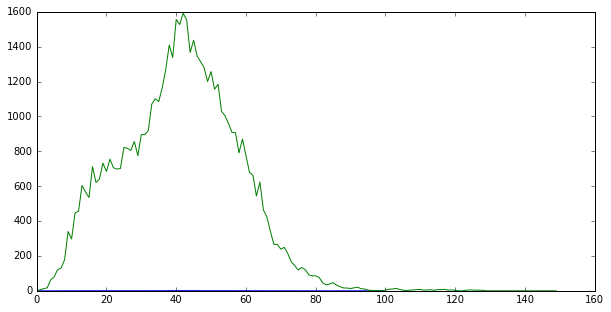

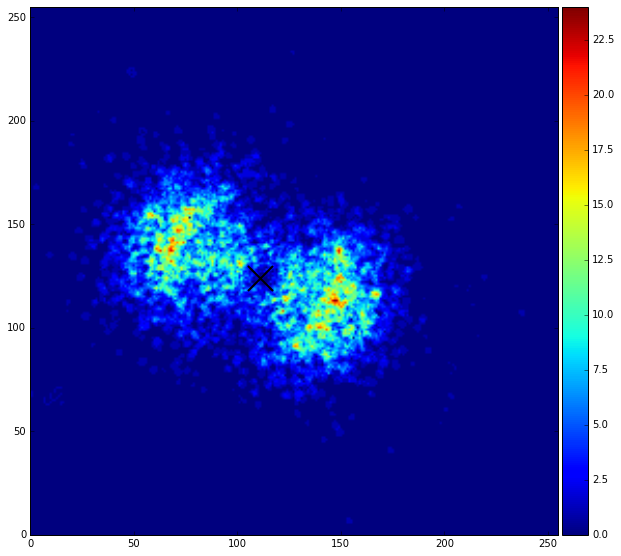

In [10]:
x = 111
y = 124

width = 10
peak = 8267
TMIN = peak - width
TMAX = peak + width
# TMIN = 8257
# TMAX = 8277
image = MakeVMIImage()
PlotRadial(image,x,y)
# pl.plot(range(150),moving_average(radial,1)[0:150])
pl.plot(range(150),moving_average(radial,1)[0:150])
pl.show()
ShowVMI(centroids=[y,x],centroided=False, cmap = 'jet')
# pl.show()

In [ ]:
dts = []
for i,_ in enumerate(events):
    if i == 0: continue
    dt = events[i] - events[i-1]
    dts.append(dt)

In [ ]:
pl.hist(dts)

In [ ]:
for i in range(1,len(dts)):
tot = np.sum(dts[0:i])
print tot, '\',i*100., '\', i*100. - tot

In [5]:
from scipy.signal import find_peaks_cwt as findpeaks
import scipy.ndimage as ndimage

# %matplotlib
%matplotlib inline  

from os import listdir
from os.path import join as join
import glob as glob
import re
import numpy as np
import pylab as pl
import string
import time
from time import sleep
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import Image, ImageDraw
from PIL import Image, ImageDraw

import sys
import math, random
from itertools import product
from ufarray import *

def run(img):
    data = img.load()
    width, height = img.size

    # Union find data structure
    uf = UFarray()

    #
    # First pass
    #

    # Dictionary of point:label pairs
    labels = {}

    for y, x in product(range(height), range(width)):

        #
        # Pixel names were chosen as shown:
        #
        #   -------------
        #   | a | b | c |
        #   -------------
        #   | d | e |   |
        #   -------------
        #   |   |   |   |
        #   -------------
        #
        # The current pixel is e
        # a, b, c, and d are its neighbors of interest
        #
        # 255 is white, 0 is black
        # White pixels part of the background, so they are ignored
        # If a pixel lies outside the bounds of the image, it default to white
        #

        # If the current pixel is white, it's obviously not a component...
        if data[x, y] == 255:
            pass

        # If pixel b is in the image and black:
        #    a, d, and c are its neighbors, so they are all part of the same component
        #    Therefore, there is no reason to check their labels
        #    so simply assign b's label to e
        elif y > 0 and data[x, y-1] == 0:
            labels[x, y] = labels[(x, y-1)]

        # If pixel c is in the image and black:
        #    b is its neighbor, but a and d are not
        #    Therefore, we must check a and d's labels
        elif x+1 < width and y > 0 and data[x+1, y-1] == 0:

            c = labels[(x+1, y-1)]
            labels[x, y] = c

            # If pixel a is in the image and black:
            #    Then a and c are connected through e
            #    Therefore, we must union their sets
            if x > 0 and data[x-1, y-1] == 0:
                a = labels[(x-1, y-1)]
                uf.union(c, a)

            # If pixel d is in the image and black:
            #    Then d and c are connected through e
            #    Therefore we must union their sets
            elif x > 0 and data[x-1, y] == 0:
                d = labels[(x-1, y)]
                uf.union(c, d)

        # If pixel a is in the image and black:
        #    We already know b and c are white
        #    d is a's neighbor, so they already have the same label
        #    So simply assign a's label to e
        elif x > 0 and y > 0 and data[x-1, y-1] == 0:
            labels[x, y] = labels[(x-1, y-1)]

        # If pixel d is in the image and black
        #    We already know a, b, and c are white
        #    so simpy assign d's label to e
        elif x > 0 and data[x-1, y] == 0:
            labels[x, y] = labels[(x-1, y)]

        # All the neighboring pixels are white,
        # Therefore the current pixel is a new component
        else: 
            labels[x, y] = uf.makeLabel()

    #
    # Second pass
    #

    uf.flatten()

    colors = {}

    # Image to display the components in a nice, colorful way
    output_img = Image.new("RGB", (width, height))
    outdata = output_img.load()

    clusters = {}

    for (x, y) in labels:

        # Name of the component the current point belongs to
        component = uf.find(labels[(x, y)])

        # Update the labels with correct information
        labels[(x, y)] = component

         # Associate a random color with this component 
        if component not in colors: 
            colors[component] = (random.randint(0,255), random.randint(0,255),random.randint(0,255))

        if component not in clusters:
            clusters[component] = []
            clusters[component].append([x,y]) 
        else:
            clusters[component].append([x,y]) 

        # Colorize the image
        outdata[x, y] = colors[component]

    return (labels, output_img, clusters)

def ClusterFind(data):
    # Create image from numpy array
    img = Image.fromarray(data)
#     print list(img.getdata())


    # Threshold the image, this implementation is designed to process b+w
    # images only
#     img = img.point(lambda p: p > 190 and 255)
    img = img.convert('1')

    # labels is a dictionary of the connected component data in the form:
    #     (x_coordinate, y_coordinate) : component_id
    #
    # if you plan on processing the component data, this is probably what you
    # will want to use
    #
    # output_image is just a frivolous way to visualize the components.
    (labels, output_img, clusters) = run(img)

    return labels, output_img, clusters

#     output_img.show()
#     fig = pl.figure(figsize = [10,10])
#     ax = fig.add_subplot(111)
#     im = ax.imshow(output_img)

###################################################

def FilenameToFileID(_filename):
    y, mo, d, h, mins, s, ms = [float(__) for __ in (re.split('\\_|\\.', _filename[len(data_path) + len(prefix):-4])) if __ !='txt']
    time = ms + (1000*s) + (1000*60*mins) + (1000*60*60*h) + (1000*60*60*24)
    return time

###################################################

def GetTimecodes_SingleFile(_filename, winow_xmin = 0, winow_xmax = 999, winow_ymin = 0, winow_ymax = 999, t_min=0, t_max=11811):
    _timecodes = []

    datafile = open(_filename)
    lines = datafile.readlines()
    skiprows = 0

    if len(lines) > GLITCH_THRESHOLD:
#         print 'Skipped glitch'
        return [] #skip bad files (glitches)
    for line in lines[skiprows:]:
        _x,_y,_timecode = string.split(str(line),'\t')
        _x = int(_x)
        _y = int(_y)
        _timecode = int(_timecode)
        if _x>=winow_xmin and _x<=winow_xmax and _y>=winow_ymin and _y<=winow_ymax:
            if _timecode>=t_min and _timecode<=t_max:
                _timecodes.append(_timecode)
                global_TOF[_timecode]+=1
    return _timecodes

###################################################

def moving_average(a, n=2) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

###################################################

def GetXYTarray_SingleFile(_filename, winow_xmin = 0, winow_xmax = 999, winow_ymin = 0, winow_ymax = 999, t_min=0, t_max=11811):
    _xs, _ys, _ts = [], [], []

    data = pl.loadtxt(_filename, usecols = (0,1,2), skiprows=1)

    #handle problem with the way loadtxt reads single line data files
    if data.shape == (3,): 
        _x = int(data[0])
        _y = int(data[1])
        _timecode = int(data[2])
        if _x>=winow_xmin and _x<=winow_xmax and _y>=winow_ymin and _y<=winow_ymax:
            if _timecode>=t_min and _timecode<=t_max:
                _xs.append(_x)
                _ys.append(_y)
                _ts.append(_timecode)
                global_TOF[_timecode]+=1
        return _xs, _ys, _ts 

    #extract data for multiline files
    if len(data) > GLITCH_THRESHOLD:
#         print 'Skipped glitch'
        return [],[],[] #skip glitch files
    for i in range(len(data)):
        _x = int(data[i,0])
        _y = int(data[i,1])
        _timecode = int(data[i,2])
        if _x>=winow_xmin and _x<=winow_xmax and _y>=winow_ymin and _y<=winow_ymax:
            if _timecode>=t_min and _timecode<=t_max:
                _xs.append(_x)
                _ys.append(_y)
                _ts.append(_timecode)
                global_TOF[_timecode]+=1
    return _xs, _ys, _ts 

###################################################

def MakeVMIImage():
    global image
    image = np.zeros((256,256), dtype = np.int32)

#     index = np.where()
    
    for _x,_y,_t in zip(global_xs,global_ys,global_ts):
        if _x>=XMIN and _x<=XMAX and _y>=YMIN and _y<=YMAX:
            if _t>=TMIN and _t<=TMAX:
                image[_x,_y] += 1
    return image

###################################################

def MakeVMIImageCentroided():
    global image_centroided
    image_centroided = np.zeros((256,256), dtype = np.int32)

    for _x,_y,_t in zip(global_xs_cent,global_ys_cent,global_ts_cent):
        if _x>=XMIN and _x<=XMAX and _y>=YMIN and _y<=YMAX:
            if _t>=TMIN and _t<=TMAX:
                image_centroided[_x,_y] += 1

###################################################

def TimepixFileToImage(_filename, winow_xmin = 0, winow_xmax = 999, winow_ymin = 0, winow_ymax = 999, t_min=0, t_max=11811):
    global global_TOF

    image = np.zeros((256,256), dtype = np.float)
    data = pl.loadtxt(_filename, usecols = (0,1,2), skiprows=1)

    #handle problem with the way loadtxt reads single line data files
    if data.shape == (3,): 
        _x = int(data[0])
        _y = int(data[1])
        _timecode = int(data[2])
        if _x>=winow_xmin and _x<=winow_xmax and _y>=winow_ymin and _y<=winow_ymax:
            if _timecode>=t_min and _timecode<=t_max:
                image[_x,_y] += _timecode
                global_TOF[_timecode]+=1
        return image

    #extract data for multiline files
    if len(data) > GLITCH_THRESHOLD:
#         print 'Skipped glitch'
        return image
    for i in range(len(data)):
        _x = int(data[i,0])
        _y = int(data[i,1])
        _timecode = int(data[i,2])
        if _x>=winow_xmin and _x<=winow_xmax and _y>=winow_ymin and _y<=winow_ymax:
            if _timecode>=t_min and _timecode<=t_max:
                image[_x,_y] += _timecode
                global_TOF[_timecode]+=1
    return image

###################################################

def DisplayImage(image, vmin=None, vmax=None):
    fig = pl.figure(figsize = [10,10])
    ax = fig.add_subplot(111)
    ax.set_xlim([YMIN,YMAX])
    ax.set_ylim([XMIN,XMAX])

    if vmax == 'auto':
        element = (256*256) - 200
        tmp = image.flatten()
        tmp.sort()
        vmax = tmp[element]
        vmin = tmp[200]
        print 'Auto vmax = %s'%vmax

    if vmin == 'auto':
        tmp = image.flatten()
        vmin = min(_ for _ in tmp if _ > 0)
        print 'Auto vmin = %s'%vmin

    im = ax.imshow(image, vmin=vmin, vmax=vmax)
    fig.colorbar(im)
    

###################################################

def LoadFiles(maxfiles=1e9, centroid=True):
    av_ions_per_frame = 0.0
    n_loaded = 0
    filenames = glob.glob(join(data_path, prefix))
    t0 = time.time()
    for _filename in filenames:
#         try:
        _fileID = FilenameToFileID(_filename)
        if _fileID not in loaded_files:
            if n_loaded >= maxfiles: break
            loaded_fileNAMES.append(_filename)
            loaded_files.append(_fileID)
            n_loaded += 1
            if n_loaded%100 == 0:
                dt = time.time() - t0
                print 'Loaded %s files in %.0f ms' %(n_loaded, dt*1e3)
                t0 = time.time()
            if centroid:
                dummy, _xs, _ys, _ts = GetCentroidsXYTFromFile(_filename)#[1:4]
                av_ions_per_frame += len(_ts)
                del dummy
                for _t in _ts:
                    global_TOF_centroided[int(_t)]+=1
                global_xs_cent.extend(_xs)
                global_ys_cent.extend(_ys)
                global_ts_cent.extend(_ts)
            _xs, _ys, _ts = GetXYTarray_SingleFile(_filename)
            global_xs.extend(_xs)
            global_ys.extend(_ys)
            global_ts.extend(_ts)
    #         except:
#             print "Error in %s"%_filename

    print 'Finished loading %s more files'%n_loaded
    if n_loaded >=1: print 'Average ions/frame = %s'%(av_ions_per_frame/float(n_loaded))

###################################################

def ShowExampleImage(tcut=0):
    if len(loaded_fileNAMES) <= 0: LoadFiles(maxfiles=1)
    _filename = loaded_fileNAMES[-1]
    
    _image = TimepixFileToImage(_filename)
    _image[_image == 0] = np.nan
    _image[_image < tcut] = np.nan
    
    fig = pl.figure(figsize = [15,15])

    ax1 = fig.add_subplot(121)
    im1 = ax1.imshow(_image)
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    pl.colorbar(im1, cax=cax)
#################

    output_img, dummy1, dummy2, dummy3 = GetCentroidsXYTFromFile(_filename)
    ax2 = fig.add_subplot(122)
    #     im1 = ax1.imshow(np.fliplr(np.rot90(image_centroided,3)), vmax=vmax_cent, interpolation='gaussian')
    im2 = ax2.imshow(output_img)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    pl.colorbar(im2, cax=cax)

    ax1.set_xlim([YMIN,YMAX])
    ax1.set_ylim([XMIN,XMAX])
    ax2.set_xlim([YMIN,YMAX])
    ax2.set_ylim([XMIN,XMAX])

    
#     DisplayImage(_image, vmin='auto')



###################################################

def ShowVMI(centroided=False, vmax=None, centroids = [0,0], zoom=([0,255],[0,255]), cmap = 'jet'):
    if centroided:
        fig = pl.figure(figsize = [15,15])
        if vmax == 'auto':
            element = (256*256) - 200
            tmp = image.flatten()
            tmp_cent = image_centroided.flatten()
            tmp.sort()
            tmp_cent.sort()
            vmax_raw = tmp[element]
            vmax_cent = tmp_cent[element]
            print 'vmax = %s'%vmax
        else:
            vmax_cent = np.max(image_centroided)
        
        ax1 = fig.add_subplot(121)
        im1 = ax1.imshow(np.fliplr(np.rot90(image_centroided,3)), vmax=vmax_cent, interpolation='gaussian')
        
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        pl.colorbar(im1, cax=cax)
        
        ax2 = fig.add_subplot(122)
        im2 = ax2.imshow(image, vmax=vmax_raw)
        
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        pl.colorbar(im2, cax=cax)
        
        ax1.set_xlim([YMIN,YMAX])
        ax1.set_ylim([XMIN,XMAX])
        ax2.set_xlim([YMIN,YMAX])
        ax2.set_ylim([XMIN,XMAX])
    else:
        fig = pl.figure(figsize = [10,10])
        ax1 = fig.add_subplot(111)
        if vmax == 'auto':
            element = (256*256) - 200
            tmp = image.flatten()
            tmp.sort()
            vmax = tmp[element]
            print 'vmax = %s'%vmax
        im1 = ax1.imshow(image, vmax=vmax, cmap=cmap)
        ax1.set_xlim(zoom[0][0],zoom[0][1])
        ax1.set_ylim(zoom[1][0],zoom[1][1])
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        pl.colorbar(im1, cax=cax)
        if centroids != [0,0]:
            ax1.plot([centroids[1]], [centroids[0]], marker='x', c='k', ms=25., mew=2)
        
    
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)

# plt.colorbar(im, cax=cax)

###################################################

# def ShowTOF(flip=False, centroided=False):
#     fig = pl.figure(figsize = [10,10])
#     ax = fig.add_subplot(111)
#     ax.set_xlim([TOF_TMIN,TOF_TMAX])

#     if centroided:
#         tof = pl.plot(range(11810),global_TOF_centroided) 
#     else:
#         tof = pl.plot(range(11810),global_TOF)       
#     if flip: pl.xlim(pl.xlim()[::-1])
#     return ax        
###################################################
def ShowTOF(flip=False, centroided=False, v_scale=1.):
    global peaks_raw
    global peaks_centroided

    PEAK_SETTINGS_CENTROIDED = {}
    PEAK_SETTINGS_CENTROIDED['vector'] = global_TOF_centroided
    PEAK_SETTINGS_CENTROIDED['widths'] = np.asarray([3])
    PEAK_SETTINGS_CENTROIDED['min_snr']    = [0.015]
    PEAK_SETTINGS_CENTROIDED['noise_perc'] = [0.0001]

    PEAK_SETTINGS_RAW = {}
    PEAK_SETTINGS_RAW['vector'] = global_TOF
    PEAK_SETTINGS_RAW['widths'] = np.asarray([6])
    PEAK_SETTINGS_RAW['min_snr']    = [0.025]
    PEAK_SETTINGS_RAW['noise_perc'] = [0.0001]

    peaks_raw = findpeaks( **PEAK_SETTINGS_RAW)

    if centroided:
        peaks_centroided = findpeaks( **PEAK_SETTINGS_CENTROIDED)

        fig = pl.figure(figsize=[16,8])
        ax_cent = pl.subplot(212)
        ax_raw  = pl.subplot(211, sharex=ax_cent)
        tof1 = ax_cent.plot(range(11810),global_TOF_centroided)
        tof2 =  ax_raw.plot(range(11810),global_TOF)
        ax_cent.set_ylim([0,max(global_TOF_centroided[TOF_TMIN:TOF_TMAX])])
        ax_raw.set_ylim([0,max(global_TOF[TOF_TMIN:TOF_TMAX])])
        ax_cent.set_xlim([TOF_TMIN,TOF_TMAX])
        ax_raw.set_xlim([TOF_TMIN,TOF_TMAX])
        
        ax_cent.set_ylim([0,v_scale*max(global_TOF_centroided)])
        ax_raw.set_ylim([0,v_scale*max(global_TOF)])
        if flip:
            ax_cent.set_xlim(ax_cent.get_xlim()[::-1])
        ax_cent.set_title('ToF Centroided')
    else:
        fig = pl.figure(figsize=[16,4])
        ax_raw = pl.subplot(111)
        tof = ax_raw.plot(range(11810),global_TOF) 
        ax_raw.set_xlim([TOF_TMIN,TOF_TMAX])
        if flip: pl.xlim(pl.xlim()[::-1])
        ax_cent = None

    pl.xlabel('ToF (timecodes)', horizontalalignment = 'right' )

    FilterPeaks()
    print '       Raw peaks found at %s'%peaks_raw[::-1]
    print 'Centroided peaks found at %s'%peaks_centroided[::-1]
    

    if ax_cent is not None:
        for peak in peaks_centroided:
            ax_cent.plot([peak, peak], [0, ax_cent.get_ylim()[1]], color='k', linestyle='--', linewidth=1)

    for peak in peaks_raw:
        ax_raw.plot([peak, peak], [0, ax_raw.get_ylim()[1]], color='k', linestyle='--', linewidth=1)

    ax_raw.set_title('ToF RAW')

#     f.savefig(out_path + 'ToF.png')
    pl.show()

    return ax_raw, ax_cent

###################################################

def FilterPeaks():
    import operator
    search_range = 5
    cent_threshold = len(loaded_fileNAMES) / 10
    raw_threshold = len(loaded_fileNAMES) * 2
    global peaks_centroided
    global peaks_raw
    new_peaks_centroided = []
    new_peaks_raw = []

    for peak in peaks_centroided:
        _min = max(peak - search_range, 0)
        _max = min(peak + search_range, len(global_TOF_centroided))
        index, maxval = max(enumerate(global_TOF_centroided[_min:_max]), key=operator.itemgetter(1))
        if maxval >= cent_threshold:
            new_peaks_centroided.append(_min+index)

    for peak in peaks_raw:
        _min = max(peak - search_range, 0)
        _max = min(peak + search_range, len(global_TOF))
        index, maxval = max(enumerate(global_TOF[_min:_max]), key=operator.itemgetter(1))
        if maxval >= raw_threshold:
            new_peaks_raw.append(_min+index)

    peaks_centroided = new_peaks_centroided
    peaks_raw = new_peaks_raw

###################################################

def GetMaxCodeFromCluster(cluster, _original_image):
    _timecodes = []
    for [x,y] in cluster:
        _timecodes.append(_original_image[y,x])     
    return max(_timecodes)

###################################################

def GetCentroidFromCluster(cluster):
    totalmass, totalx, totaly = 0.0,0.0,0.0
    for [x,y] in cluster:
        totalmass += 1.
        totalx += float(x+0.5)
        totaly += float(y+0.5)
    return [totalx/totalmass,totaly/totalmass]

###################################################

def GetCentroidsXYTFromFile(_filename, winow_xmin = 0, winow_xmax = 999, winow_ymin = 0, winow_ymax = 999, t_min=0, t_max=11811):
    _xs, _ys, _ts = [], [], []

    cluster_image = TimepixFileToImage(_filename)
    _original_image = np.copy(cluster_image)

    # my_image[my_image == 0] = np.nan
    # my_image[my_image < tcut] = np.nan
    # my_image[my_image > tcut] = 253

    # my_image[my_image == 0] = np.nan
    cluster_image[cluster_image < TCUT] = 255
    cluster_image[cluster_image > TCUT] = 0

    # DisplayImage(my_image, vmin='auto')

    dummy, output_img, clusters = ClusterFind(cluster_image)
    del dummy
    if len(clusters) == 1:
        print 'Found %s clusters in %s - TCUT = %s'%(len(clusters), _filename, TCUT)
    for key in clusters:
        max_t = GetMaxCodeFromCluster(clusters[key], _original_image)
        centroid_x, centroid_y = GetCentroidFromCluster(clusters[key])
        _xs.append(centroid_x)
        _ys.append(centroid_y)
        _ts.append(max_t)
    del cluster_image, _original_image
    return output_img, _xs, _ys, _ts

###################################################

def ShowClusteredImage():
    output_img, dummy1, dummy2, dummy3 = GetCentroidsXYTFromFile(loaded_fileNAMES[-1])
    fig = pl.figure(figsize = [10,10])
    ax = fig.add_subplot(111)
    im = ax.imshow(output_img)
    
###################################################
    
def Reset():
    global loaded_files 
    global loaded_fileNAMES
    global global_xs 
    global global_ys 
    global global_ts 

    global global_xs_cent 
    global global_ys_cent 
    global global_ts_cent 

    global image
    global image_centroided 
    global global_TOF
    global global_TOF_centroided
    global peaks_raw
    global peaks_centroided
#     global mini_ims
    global disp_images 
    global radial
    
    loaded_files = []
    loaded_fileNAMES = []

    global_xs = []
    global_ys = []
    global_ts = []

    global_xs_cent = []
    global_ys_cent = []
    global_ts_cent = []

    image = np.zeros((256,256), dtype = np.int32)
    image_centroided = np.zeros((256,256), dtype = np.int32)
    global_TOF = np.zeros(11810, dtype = np.int32)
    global_TOF_centroided = np.zeros(11810, dtype = np.int32)
    radial = np.zeros((256), dtype = np.float)
    peaks_raw = []
    peaks_centroided = []
#     mini_ims = []
    disp_images = []
    
def MakeImageAroundPeak(peak,peak_dist):
    _image = np.zeros((256,256), dtype = np.int32)
    for _x,_y,_t in zip(global_xs,global_ys,global_ts):
        if _x>=XMIN and _x<=XMAX and _y>=YMIN and _y<=YMAX:
            if _t>=peak-peak_dist and _t<=peak+peak_dist:
                _image[_x,_y] += 1
    return _image

###################################################

def ShowEverything(recreate=False):
    import matplotlib.gridspec as gridspec
    global disp_images
    
    fig = pl.figure(figsize = [12,12])
    gs = gridspec.GridSpec(5,5)
    # NB subplot[y,x]!!!
    tof1 = pl.subplot(gs[4, :])
    VMI_main = pl.subplot(gs[0:4,0:4])
    mini_list = [pl.subplot(gs[i,-1]) for i in range(4)]
    
    
    # Draw TOF
    tof1.plot(range(11810),global_TOF)
    tof1.set_ylim([0,max(global_TOF[TOF_TMIN:TOF_TMAX])])
    tof1.set_xlim([TOF_TMIN,TOF_TMAX])
    tof1.set_xlim([TOF_TMIN,TOF_TMAX])
    tof1.set_xlim(tof1.get_xlim()[::-1])
    
    if recreate:
        disp_images = []
        MakeVMIImage()
        for i,peak in enumerate(peaks_raw[0:4]):
            disp_images.append(MakeImageAroundPeak(peak,5))
            print 'Created %s mini VMIs'
    
    VMI_im = VMI_main.imshow(image, vmax=np.amax(image)/2)
    divider = make_axes_locatable(VMI_main)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    pl.colorbar(VMI_im, cax=cax)

    mini_ims = []
    for i,peak in enumerate(peaks_raw[0:4]):
        mini_ims.append(mini_list[i].imshow(disp_images[i], vmax=np.amax(disp_images[i])*1))
        divider = make_axes_locatable(mini_list[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        pl.colorbar(mini_ims[i], cax=cax)
        mini_list[i].get_xaxis().set_ticks([])
        mini_list[i].get_yaxis().set_ticks([])

    
    pl.show()

###################################################

def LoadLastFiles(nfiles = 100, clear = False, centroid=True):
    if clear: Reset()
    n_loaded = 0
    filenames = glob.glob(join(data_path, prefix))
    t0 = time.time()
    _files = {}
    
    for _filename in filenames:
        _id = FilenameToFileID(_filename)
        _files[_id] = _filename
        
    for _fileID in sorted(_files.keys())[-1*nfiles:]:
        _filename = _files[_fileID]
#         print _filename
        if _fileID not in loaded_files:
            if n_loaded >= nfiles: break
            loaded_fileNAMES.append(_filename)
            loaded_files.append(_fileID)
            n_loaded += 1
            if n_loaded%100 == 0:
                dt = time.time() - t0
                print 'Loaded %s files in %.0f ms' %(n_loaded, dt*1e3)
                t0 = time.time()
            if centroid:
                dummy, _xs, _ys, _ts = GetCentroidsXYTFromFile(_filename)#[1:4]
                del dummy
                for _t in _ts:
                    global_TOF_centroided[int(_t)]+=1
                global_xs_cent.extend(_xs)
                global_ys_cent.extend(_ys)
                global_ts_cent.extend(_ts)
            _xs, _ys, _ts = GetXYTarray_SingleFile(_filename)
            global_xs.extend(_xs)
            global_ys.extend(_ys)
            global_ts.extend(_ts)

    print 'Finished loading last %s files'%n_loaded
    
###################################################

def PlotRadial(image, x_cent, y_cent):
    global radial
    radial = np.zeros((363), dtype = np.float64)
    
    for x in range(256):
        for y in range(256):
            dist = np.round(np.sqrt((x-x_cent)**2 + (y-y_cent)**2),0)
            radial[int(dist)] += image[y,x]

    fig = pl.figure(figsize=[10,5])
    ax = fig.add_subplot(111)
    ax.plot(range(100),radial[0:100]/max(radial[0:100]))
    
###################################################
    
def GetCentroid(image):
#     threshold = np.percentile(image,99.99)
    temp_image = np.copy(image)
#     temp_image[temp_image > threshold] = 0
    _y_centre,_x_centre  = ndimage.measurements.center_of_mass(temp_image)
    return _x_centre, _y_centre

###################################################

def ShowTOF_AMU(flip=False, centroided=False, v_scale=1., T0=8600, VOLTAGE=1630, max_amu = 400):
    global peaks_raw
    global peaks_centroided

    PEAK_SETTINGS_CENTROIDED = {}
    PEAK_SETTINGS_CENTROIDED['vector'] = global_TOF_centroided
    PEAK_SETTINGS_CENTROIDED['widths'] = np.asarray([3])
    PEAK_SETTINGS_CENTROIDED['min_snr']    = [0.015]
    PEAK_SETTINGS_CENTROIDED['noise_perc'] = [0.0001]

    PEAK_SETTINGS_RAW = {}
    PEAK_SETTINGS_RAW['vector'] = global_TOF
    PEAK_SETTINGS_RAW['widths'] = np.asarray([6])
    PEAK_SETTINGS_RAW['min_snr']    = [0.025]
    PEAK_SETTINGS_RAW['noise_perc'] = [0.0001]

    peaks_raw = findpeaks( **PEAK_SETTINGS_RAW)
    peaks_centroided = findpeaks( **PEAK_SETTINGS_CENTROIDED)
    FilterPeaks()

    peaks_raw = [T0 - _ for _ in peaks_raw]
    peaks_centroided = [T0 - _ for _ in peaks_centroided]
    
    x_axis = [T0 - _ for _ in range(11810)]
    AMU_TMIN = -100
    AMU_TMAX = max_amu

    fig = pl.figure(figsize=[16,8])
    ax_cent = pl.subplot(212)
    ax_raw  = pl.subplot(211, sharex=ax_cent)
    tof1 = ax_cent.plot(x_axis,global_TOF_centroided)
    tof2 =  ax_raw.plot(x_axis,global_TOF)
    
    ax_cent.set_xlim([AMU_TMIN,AMU_TMAX])
    ax_raw.set_xlim([AMU_TMIN,AMU_TMAX])
    ax_cent.set_ylim([0,v_scale*max(global_TOF_centroided)])
    ax_raw.set_ylim([0,v_scale*max(global_TOF)])
    
    ax_cent.set_title('ToF Centroided')

    pl.xlabel('ToF (timecodes)', horizontalalignment = 'right' )

    print '       Raw peaks found at %s'%peaks_raw[::-1]
    print 'Centroided peaks found at %s'%peaks_centroided[::-1]
    

    for peak in peaks_centroided:
        ax_cent.plot([peak, peak], [0, ax_cent.get_ylim()[1]], color='k', linestyle='--', linewidth=1)

    for peak in peaks_raw:
        ax_raw.plot([peak, peak], [0, ax_raw.get_ylim()[1]], color='k', linestyle='--', linewidth=1)

    ax_raw.set_title('ToF RAW')

#     f.savefig(out_path + 'ToF.png')
    pl.show()

    return ax_raw, ax_cent

###################################################

    
print 'Loaded functions'

Loaded functions


In [ ]:
TMIN = 7800
TMAX = 7900

image = MakeVMIImage()
x,y = GetCentroid(image)
print x,y
PlotRadial(image,x,y)

ShowVMI(centroids=[x,y])

In [ ]:
TOF_TMIN = 7800
TOF_TMAX = 8600
ShowTOF(flip=True,  centroided=True)

In [ ]:
ShowTOF_AMU(T0 = 8500)